In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

pd.options.mode.chained_assignment = None

## Import Datasets and Data Pre-Processing

In [2]:
df_items0 = pd.read_csv("items.csv", sep = "|")
### 大部分的campaignIndex都是遺失值，所以刪除
del df_items0["campaignIndex"]
print("Shape of item imformation :", df_items0.shape)

### 將大小寫統一
df_items0.pharmForm = df_items0.pharmForm.str.upper()

### 處理content的資料型態
content = pd.DataFrame(df_items0.content.str.split('X',2).tolist(), columns = ['x','y','z'])
content = content.fillna('1')
content.x = pd.to_numeric(content.x, errors='coerce')
content.y = pd.to_numeric(content.y, errors='coerce')
content.z = pd.to_numeric(content.z, errors='coerce')
content['Content'] = content.x * content.y * content.z
df_items1 = pd.concat([df_items0, content], axis=1, join_axes=[df_items0.index])
del df_items1["x"]
del df_items1["y"]
del df_items1["z"]
del df_items1["content"]

### 將categorical columns轉成數字型態
df_items1.group = df_items1.group.astype("category").cat.codes
df_items1.unit = df_items1.unit.astype("category").cat.codes
df_items1.pharmForm = df_items1.pharmForm.astype("category").cat.codes

### Missing value
df_items1.category = df_items1.category.fillna(value = np.mean(df_items1.category))
df_items1.Content = df_items1.Content.fillna(value = np.mean(df_items1.Content))

display(df_items1.isnull().sum())
df_items1.head()

Shape of item imformation : (22035, 10)


pid               0
manufacturer      0
group             0
unit              0
pharmForm         0
genericProduct    0
salesIndex        0
category          0
rrp               0
Content           0
dtype: int64

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,529,7,135,0,40,113.933996,10.89,80.0
1,2,1,529,7,135,0,40,113.933996,10.89,80.0
2,3,1,529,1,45,0,40,113.933996,16.45,10.0
3,4,1,529,7,135,0,40,113.933996,10.89,80.0
4,5,2,74,7,112,0,40,1.000000,22.53,8.0


In [3]:
df_train0 = pd.read_csv("train.csv", sep = "|")
print("Shape of training dataset :", df_train0.shape)

### Transfer to regression question
df_train0["number"] = df_train0["revenue"]/df_train0["price"]

### Transfer to classification question
click = df_train0[(df_train0.click == 1)]
basket = df_train0[(df_train0.basket == 1)]
order = df_train0[(df_train0.order == 1)]
click["class_label"] = 0
basket["class_label"] = 0
order["class_label"] = 1
df_train = pd.concat([click, basket, order])
df_train = df_train.drop(["click", "basket", "order"], axis = 1)

### Missing value
df_train.competitorPrice = df_train.competitorPrice.fillna(value = np.mean(df_train.competitorPrice))

df_train = df_train.sort_values(['lineID'], ascending = True).reset_index(drop = True)
display(df_train.isnull().sum())
df_train.head()

Shape of training dataset : (2756003, 11)


lineID             0
day                0
pid                0
adFlag             0
availability       0
competitorPrice    0
price              0
revenue            0
number             0
class_label        0
dtype: int64

,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,number,class_label
0,1,1,6570,0,2,14.60,16.89,0.00,0.0,0
1,2,1,14922,1,1,8.57,8.75,0.00,0.0,0
2,3,1,16382,0,1,14.77,16.06,0.00,0.0,0
3,4,1,1145,1,1,6.59,6.55,6.55,1.0,1
4,5,1,3394,0,1,4.39,4.14,4.14,1.0,1


In [4]:
df0 = pd.merge(df_train, df_items1, how='inner', on=['pid'])
df0 = df0.sort_values(['lineID'], ascending = True).reset_index(drop = True)
print("Shape of merged dataset :", df0.shape)
df0.head()

Shape of merged dataset : (2756003, 19)


,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,number,class_label,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,6570,0,2,14.60,16.89,0.00,0.0,0,255,529,5,147,0,40,193.0,18.25,50.0
1,2,1,14922,1,1,8.57,8.75,0.00,0.0,0,18,373,7,135,1,40,66.0,18.81,50.0
2,3,1,16382,0,1,14.77,16.06,0.00,0.0,0,41,503,5,130,0,53,40.0,18.48,100.0
3,4,1,1145,1,1,6.59,6.55,6.55,1.0,1,52,308,1,44,0,40,25.0,9.31,60.0
4,5,1,3394,0,1,4.39,4.14,4.14,1.0,1,90,458,7,75,0,53,14.0,8.13,50.0


In [5]:
pid = df0.groupby("pid")["revenue"].aggregate({"pid_sum_of_revenue": "sum", "pid_count": "count"}).reset_index()
pid.head()

,pid,pid_sum_of_revenue,pid_count
0,1,7.28,8
1,2,0.00,3
2,3,0.00,14
3,4,59.22,13
4,5,0.00,29


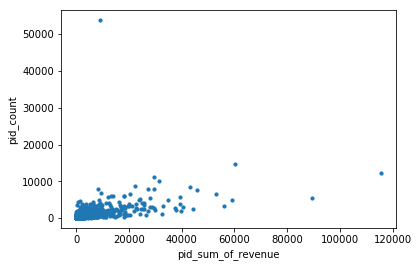

In [6]:
import matplotlib.pyplot as plt
pid.plot.scatter(x = "pid_sum_of_revenue", y = "pid_count", s = 10, c = None)
plt.show()

### 對於不重要的商品做篩選

In [7]:
### total sum
s1 = pid.sum(axis = 0)
print("Size of pid :", pid.shape[0])
### sum after threshold
t = 180
condition = (pid.pid_sum_of_revenue > t)
pid_revenue_big = pid[condition]
print("Size of revenue of pid is big :", pid_revenue_big.shape[0])
s2 = pid_revenue_big.sum(axis = 0)
print("Percent of revenue of pid selected :", s2.iloc[1]/s1.iloc[1])

Size of pid : 21928
Size of revenue of pid is big : 6739
Percent of revenue of pid selected : 0.931609953722


In [8]:
df1 = df0[df0.day < 62]
print("Size of training dataset in two month :", df1.shape[0])

df2 = pd.merge(df1, pid_revenue_big, how = 'inner', on = ['pid'])
df2 = df2.sort_values(['lineID'], ascending = True).reset_index(drop = True)
print("Size of training dataset after selecting :", df2.shape[0])
df2.head()

Size of training dataset in two month : 1746818
Size of training dataset after selecting : 1440758


,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,number,class_label,...,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content,pid_sum_of_revenue,pid_count
0,2,1,14922,1,1,8.57,8.75,0.00,0.0,0,...,373,7,135,1,40,66.0,18.81,50.0,4829.43,2333
1,4,1,1145,1,1,6.59,6.55,6.55,1.0,1,...,308,1,44,0,40,25.0,9.31,60.0,9497.50,6833
2,5,1,3394,0,1,4.39,4.14,4.14,1.0,1,...,458,7,75,0,53,14.0,8.13,50.0,877.68,444
3,6,1,3661,0,1,13.66,10.03,10.03,1.0,1,...,249,5,83,0,52,127.0,21.60,1000.0,3444.38,475
4,7,1,3856,1,1,3.03,3.58,3.58,1.0,1,...,231,1,117,0,40,90.0,5.62,20.0,9186.28,4015


In [13]:
def split(X, y):
    from sklearn.model_selection import train_test_split
    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    return X_train, X_test, y_train, y_test

def training(model, X_train, y_train):
    from sklearn.model_selection import cross_val_score
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv = 1)
    print('cross_val_score : %.2f' % (np.sum(score) / 1))

def testing_classification(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    
    from sklearn.metrics import accuracy_score
    print('Accuracy : %.2f' % accuracy_score(y_test, y_pred))
    return y_pred

def testing_regression(model, X_test, y_test):
    pred = model.predict(X_test).reshape(y_test.shape[0], 1)  
    y_test = y_test.reshape(X_test.shape[0], 1)
    
    score = np.dot((pred - y_test).T, (pred - y_test))
    from sklearn.metrics import mean_squared_error
    score1 = mean_squared_error(y_test, pred, sample_weight = None, multioutput = 'uniform_average')
    print('===Euclidean_Distance===')
    print(score[0])
    print('===MSE===')
    print(score1)
    return pred

def plot_regression(test, pred):
    import matplotlib.pyplot as plt
    
    test = test.reshape(pred.shape[0],1)
    a = np.append(pred, test, axis=1)
    b = pd.DataFrame(a)
    b.columns = ["pred", "test"]  
    b.plot.scatter(x = 'test', y = 'pred', s = 50, alpha = 0.8)
    plt.title("scatter plot of pridiction and true")
    plt.show()


In [10]:
df3 = df2[df2.class_label == 1]
print("Size of training whose order=1 :", df3.shape[0])
print("Percent of training whose order=1 :", df3.shape[0]/df2.shape[0])
df3.head()

Size of training whose order=1 : 414911
Percent of training whose order=1 : 0.287981048864556


,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,number,class_label,...,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content,pid_sum_of_revenue,pid_count
1,4,1,1145,1,1,6.59,6.55,6.55,1.0,1,...,308,1,44,0,40,25.0,9.31,60.0,9497.50,6833
2,5,1,3394,0,1,4.39,4.14,4.14,1.0,1,...,458,7,75,0,53,14.0,8.13,50.0,877.68,444
3,6,1,3661,0,1,13.66,10.03,10.03,1.0,1,...,249,5,83,0,52,127.0,21.60,1000.0,3444.38,475
4,7,1,3856,1,1,3.03,3.58,3.58,1.0,1,...,231,1,117,0,40,90.0,5.62,20.0,9186.28,4015
10,13,1,14010,0,1,19.79,19.71,19.71,1.0,1,...,261,7,-1,0,53,366.0,25.30,1.0,969.38,651


In [19]:
X = df2.drop(["revenue", "number", "class_label"], axis = 1)
Y = df2[["revenue", "number", "class_label"]]
print("Size of X :", X.shape[0])
print("Size of featrues of X :", X.shape[1])

Size of X : 1440758
Size of featrues of X : 18


In [20]:
X_train, X_test, y_train, y_test = split(X, Y["number"])

Number of training: 1152606
Number of testing: 288152


In [21]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 10, 
                            max_features = 'log2', 
                            criterion = 'mse', 
                            max_depth = None, 
                            min_samples_split = 20, 
                            min_samples_leaf = 10, 
                            min_weight_fraction_leaf = 0.0, 
                            max_leaf_nodes = None, 
                            min_impurity_split = 1e-07, 
                            bootstrap = True, 
                            oob_score = False, 
                            n_jobs = 1, 
                            random_state = 0, 
                            verbose = 0, 
                            warm_start = False)

rfr.fit(X_train, y_train)

/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

===Euclidean_Distance===
[ 269744.40206206]
===MSE===
0.936118444647


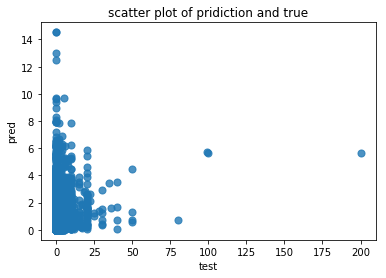

In [22]:
pred = testing_regression(rfr, X_test, y_test)
plot_regression(y_test, pred)

In [ ]:
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor(base_estimator = rfr,
                      n_estimators = 100,
                      max_samples = 1.0,
                      max_features = 1.0,
                      bootstrap = True,
                      bootstrap_features = False,
                      oob_score = False,
                      warm_start = False,
                      n_jobs = 1,
                      random_state = 0,
                      verbose = 0)
br.fit(X_train, y_train)

/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn

In [ ]:
pred_br = testing_regression(br, X_test, y_test)
plot_regression(y_test, pred_br)

> 直接用number做回歸 VS 先做分類在做回歸

In [20]:
df0_month = pd.read_csv("DATA/DMC_2017_task/month_order.csv")
df0_month.head()

,lineID,prob
0,1700002,0.800000
1,1700003,0.000000
2,1700004,0.316837
3,1700005,0.127030
4,1700006,0.334790


In [21]:
re_val = pd.merge(df0, df0_month, how='inner', on=['lineID'])
reg_val = re_val[re_val.prob > 0]
print(reg_val.shape)

(774949, 24)


In [22]:
reg_val.columns

Index([u'day', u'pid', u'click', u'basket', u'order', u'revenue', u'lineID',
       u'number', u'group', u'unit', u'pharmForm', u'campaignIndex',
       u'cluster', u'adFlag', u'availability', u'competitorPrice', u'price',
       u'manufacturer', u'genericProduct', u'salesIndex', u'category', u'rrp',
       u'Content', u'prob'],
      dtype='object')

In [23]:
reg_val1 = reg_val.drop(["day","pid",'cluster','number','lineID','click','basket','order','revenue',"group","pharmForm","unit",'campaignIndex','prob'], axis=1)
prediction = pd.DataFrame(rfr.predict(reg_val1))
prediction.columns = ["revenue"]
prediction.head()

,revenue
0,26.062774
1,7.741870
2,19.553535
3,12.311171
4,10.136568


In [24]:
reg_val = reg_val.reset_index(level = None, drop = False, inplace = False, col_level = 0, col_fill='')
prediction["lineID"] = reg_val.lineID
prediction.head()

,revenue,lineID
0,26.062774,1700002
1,7.741870,1700004
2,19.553535,1700005
3,12.311171,1700006
4,10.136568,1700008


In [25]:
re_val = re_val.merge(prediction, how='outer', on=['lineID'])
re_val.head()

,day,pid,click,basket,order,revenue_x,lineID,number,group,unit,...,competitorPrice,price,manufacturer,genericProduct,salesIndex,category,rrp,Content,prob,revenue_y
0,60,17137,1,0,0,0.0,1700002,0.0,21OIG,ST,...,0.070713,0.066971,0.331144,0.0,1.0,0.507353,0.067622,0.005443,0.800000,26.062774
1,60,8446,1,0,0,0.0,1700003,0.0,14OH2F,ST,...,0.207755,0.159522,0.145403,0.0,0.0,0.242647,0.189948,0.009080,0.000000,NaN
2,60,4265,1,0,0,0.0,1700004,0.0,2FOI,G,...,0.024869,0.018690,0.000000,0.0,0.0,0.644608,0.024154,0.000443,0.316837,7.741870
3,60,21003,1,0,0,0.0,1700005,0.0,18OZ0FIO,G,...,0.038475,0.037564,0.233583,0.0,0.0,0.058824,0.048679,0.006807,0.127030,19.553535
4,60,17221,1,0,0,0.0,1700006,0.0,20OHE,ST,...,0.062323,0.028853,0.077861,0.0,1.0,0.784314,0.107829,0.000034,0.334790,12.311171


In [26]:
r1 = re_val.revenue_y.fillna(value = 1)
r1 = pd.to_numeric(r1, errors = 'coerce')
r2 = pd.to_numeric(re_val.prob, errors = 'coerce')
re_val["exp"] = r1*r2
re_val.head()

,day,pid,click,basket,order,revenue_x,lineID,number,group,unit,...,price,manufacturer,genericProduct,salesIndex,category,rrp,Content,prob,revenue_y,exp
0,60,17137,1,0,0,0.0,1700002,0.0,21OIG,ST,...,0.066971,0.331144,0.0,1.0,0.507353,0.067622,0.005443,0.800000,26.062774,20.850219
1,60,8446,1,0,0,0.0,1700003,0.0,14OH2F,ST,...,0.159522,0.145403,0.0,0.0,0.242647,0.189948,0.009080,0.000000,NaN,0.000000
2,60,4265,1,0,0,0.0,1700004,0.0,2FOI,G,...,0.018690,0.000000,0.0,0.0,0.644608,0.024154,0.000443,0.316837,7.741870,2.452912
3,60,21003,1,0,0,0.0,1700005,0.0,18OZ0FIO,G,...,0.037564,0.233583,0.0,0.0,0.058824,0.048679,0.006807,0.127030,19.553535,2.483880
4,60,17221,1,0,0,0.0,1700006,0.0,20OHE,ST,...,0.028853,0.077861,0.0,1.0,0.784314,0.107829,0.000034,0.334790,12.311171,4.121663


In [27]:
re_val.columns
re_val.exp.shape, re_val.revenue_x.shape

((1056001,), (1056001,))

In [31]:
pred = np.array(re_val.exp).reshape(re_val.exp.shape[0], 1)
y_test = np.array(re_val.revenue_x).reshape(re_val.revenue_x.shape[0], 1)
score = np.dot((pred - y_test).T, (pred - y_test))
print('===Euclidean_Distance===')
print(score[0])

===Euclidean_Distance===
[  1.23418502e+08]


In [33]:
from sklearn.metrics import mean_squared_error
score1 = mean_squared_error(y_test, pred, sample_weight = None, multioutput = 'uniform_average')
print('===MSE===')
print(score1)    

===MSE===
116.873470292


###

In [119]:
df0_t = pd.read_csv("DATA/DMC_2017_task/test_clean.csv")
df0_t.head()

,Unnamed: 0,lineID,day,pid,group,unit,pharmForm,campaignIndex,cluster,adFlag,availability,competitorPrice,price,manufacturer,genericProduct,salesIndex,category,rrp,Content
0,0,1,93,4772,1DOIF0ZO,ML,ATR,D,2.0,0.0,0.000000,0.031271,0.031271,0.351782,0.0,1.0,0.093137,0.041813,0.000443
1,1,2,93,11548,13OX00OI,ML,LOE,D,1.0,0.0,0.333333,0.022329,0.022329,0.144465,0.0,0.0,0.294118,0.022178,0.013625
2,2,3,93,1958,13OS00,G,SAL,D,1.0,0.0,0.000000,0.026982,0.026982,0.343340,0.0,0.0,0.512255,0.036330,0.000670
3,3,4,93,15071,20OH0,ST,BAN,A,0.0,0.0,0.333333,0.042735,0.042735,0.351782,0.0,1.0,0.208333,0.054038,0.000216
4,4,5,93,2117,1COS30OQ,ML,SIR,B,1.0,0.0,0.000000,0.014141,0.014141,0.029081,0.0,0.0,0.517157,0.020178,0.005443


In [120]:
df0_or = pd.read_csv("DATA/DMC_2017_task/class_order.csv")
df0_or.head()

,lineID,prob
0,1,0.000000
1,2,0.000000
2,3,0.162257
3,4,0.000000
4,5,0.234704


In [133]:
result = pd.merge(df0_t, df0_or, how='inner', on=['lineID'])
del result["Unnamed: 0"]
print(result.shape)

(1210767, 19)


In [147]:
reg = result[result.prob > 0.5]
print(reg.shape)

(162993, 21)


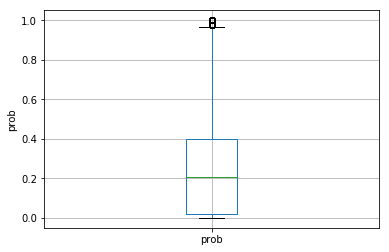

In [148]:
import pylab

result.boxplot('prob')
pylab.ylabel('prob')
plt.show()

In [135]:
reg1 = reg.drop(["day", "pid", 'lineID', "group", "pharmForm", "unit", 'campaignIndex'], axis=1)
pre_reg1 = pd.DataFrame(br.predict(reg1))
pre_reg1.columns = ["Revenue"]

In [136]:
reg = reg.reset_index(level = None, drop = False, inplace = False, col_level = 0, col_fill='')
pre_reg1["lineID"] = reg.lineID

In [137]:
result = result.merge(pre_reg1, how='outer', on=['lineID'])
result.head()

,lineID,day,pid,group,unit,pharmForm,campaignIndex,cluster,adFlag,availability,competitorPrice,price,manufacturer,genericProduct,salesIndex,category,rrp,Content,prob,Revenue
0,1,93,4772,1DOIF0ZO,ML,ATR,D,2.0,0.0,0.000000,0.031271,0.031271,0.351782,0.0,1.0,0.093137,0.041813,0.000443,0.000000,NaN
1,2,93,11548,13OX00OI,ML,LOE,D,1.0,0.0,0.333333,0.022329,0.022329,0.144465,0.0,0.0,0.294118,0.022178,0.013625,0.000000,NaN
2,3,93,1958,13OS00,G,SAL,D,1.0,0.0,0.000000,0.026982,0.026982,0.343340,0.0,0.0,0.512255,0.036330,0.000670,0.162257,20.808923
3,4,93,15071,20OH0,ST,BAN,A,0.0,0.0,0.333333,0.042735,0.042735,0.351782,0.0,1.0,0.208333,0.054038,0.000216,0.000000,NaN
4,5,93,2117,1COS30OQ,ML,SIR,B,1.0,0.0,0.000000,0.014141,0.014141,0.029081,0.0,0.0,0.517157,0.020178,0.005443,0.234704,16.978521


In [138]:
from IPython.display import display
display(result.Revenue.isnull().sum())

295334

In [139]:
r1 = result.Revenue.fillna(value = 1)
r1 = pd.to_numeric(r1, errors = 'coerce')
r2 = pd.to_numeric(result.prob, errors = 'coerce')
result["exp"] = r1*r2
result.head(100)

,lineID,day,pid,group,unit,pharmForm,campaignIndex,cluster,adFlag,availability,...,price,manufacturer,genericProduct,salesIndex,category,rrp,Content,prob,Revenue,exp
0,1,93,4772,1DOIF0ZO,ML,ATR,D,2.0,0.0,0.000000,...,0.031271,0.351782,0.0,1.000000,0.093137,0.041813,0.000443,0.000000,NaN,0.000000
1,2,93,11548,13OX00OI,ML,LOE,D,1.0,0.0,0.333333,...,0.022329,0.144465,0.0,0.000000,0.294118,0.022178,0.013625,0.000000,NaN,0.000000
2,3,93,1958,13OS00,G,SAL,D,1.0,0.0,0.000000,...,0.026982,0.343340,0.0,0.000000,0.512255,0.036330,0.000670,0.162257,20.808923,3.376395
3,4,93,15071,20OH0,ST,BAN,A,0.0,0.0,0.333333,...,0.042735,0.351782,0.0,1.000000,0.208333,0.054038,0.000216,0.000000,NaN,0.000000
4,5,93,2117,1COS30OQ,ML,SIR,B,1.0,0.0,0.000000,...,0.014141,0.029081,0.0,0.000000,0.517157,0.020178,0.005443,0.234704,16.978521,3.984928
5,6,93,21129,22OI5,ML,CRE,D,2.0,0.0,0.000000,...,0.017000,0.981238,0.0,1.000000,0.046569,0.021511,0.002261,0.204419,9.935879,2.031084
6,7,93,8977,1COJ00OZ,ST,TAB,C,1.0,0.0,0.000000,...,0.005563,0.015947,1.0,0.000000,0.115196,0.010669,0.000898,0.110440,13.125924,1.449624
7,8,93,5654,1AOK0FOS,ML,LOE,D,2.0,0.0,0.000000,...,0.034130,0.384615,0.0,0.307692,0.245098,0.040454,0.004534,0.000000,NaN,0.000000
8,9,93,3274,14OZ2F,G,CRE,D,1.0,1.0,0.000000,...,0.028438,0.328330,0.0,0.000000,0.014706,0.040454,0.002261,0.173810,12.453116,2.164470
9,10,93,15423,21OK2,ST,TAB,D,0.0,0.0,0.000000,...,0.028438,0.408068,0.0,1.000000,0.556373,0.039220,0.005443,0.178539,21.776354,3.887928


In [142]:
result.Revenue = result.Revenue.fillna(value = result.prob)
final_ans = result.iloc[:, [0, 20]]
final_ans.columns = ["lineID", "revenue"]
print(final_ans.head())

   lineID   revenue
0       1  0.000000
1       2  0.000000
2       3  3.376395
3       4  0.000000
4       5  3.984928


In [143]:
final_ans.to_csv("Uni_NCTU_1(1).csv", sep = "|", index = False)